# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# Methodlogy 
* In this notebook **2.5D** images are used for Training for **Segmentation** with `tf.data`, `tfrecord` using `Tensorflow`.  
* In a nutshell, **2.5D Image Training** is training of **3D** image like **2D** Image. 2.5D images can take leverage of the extra depth information like our typical RGB image. 2.5D Images are built from 3 channels with 2 strides 
* UNet model
* The model has 75M parameters that we need to train. To use TPU capabilities, the dataset has to be transformed into a TFRecord. I used the 2.5D image dataset created in this notebook by awsaf49: [UWMGI: 2.5D TFRecord Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data).
* "TFRecord files are created using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases".
* This notebook is compatible for both **GPU** and **TPU**. Device is automatically selected so you won't have to do anything to allocate device.
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* You can play with different models and losses.

# Reference Notebooks and Datasets 
📌 **@awsaf49 2.5D-TransUNet**:
* Train: [UWMGI: TransUnet 2.5D [Train] [TF]](https://www.kaggle.com/awsaf49/uwmgi-transunet-2-5d-train-tf/)
<!-- * Infer:  UWMGI: TransUnet 2.5D [Infer] [TF]-->

📌 **@awsaf49 Data/Dataset**:
* Dataset: [UWMGI: 2.5D TFRecord Dataset](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data)


# Install Libraries 
Using transunet and segmentation_models library

In [1]:
#!pip install  transunet
!pip install  segmentation_models


     |████████████████████████████████| 50 kB 2.7 MB/s 


# Import Libraries 


In [2]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
import efficientnet.tfkeras as efn
import sklearn
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import scipy
import warnings

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Set tf.keras as backend
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

from segmentation_models.base import functional as F


2022-07-10 11:58:14.641869: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-10 11:58:14.641983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `tf.keras` framework.


# Configuration 
This is where the hyper parameters and the optimizer are set

In [3]:
class CFG:
    competition = "uwmgi-tf"

    debug = False
    exp_name = "v4"
    comment = "UNet-efficientnetb7-128x128-aug-2.5D"
    num_classes = 3
    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "UNet"
    backbone = 'efficientnetb7'

    # Seeding for reproducibility
    seed = 101

    # Number of folds
    folds = 5

    # Which Folds to train
    selected_folds = [0, 1, 2, 3, 4]

    # Image Size
    img_size = [128, 128]

    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 15
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "dice_loss"
    optimizer = "Adam"
    lr = 5e-4
    lr_schedule = "CosineDecay"
    patience = 5

    # Augmentation
    augment = True
    transform = False

    # Transformation
    fill_mode = "constant"
    rot = 5.0  # proprtional
    shr = 5.0  # proprtional
    hzoom = 100.0  # inv proportional
    wzoom = 100.0  # inv proportional
    hshift = 10.0  # proportional
    wshift = 10.0  # proportional

    # Horizontal & Vertical Flip
    hflip = 0.5
    vflip = 0.5

    # Clip values to [0, 1]
    clip = False

    # CutOut
    drop_prob = 0.5
    drop_cnt = 10
    drop_size = 0.05

    # Jitter
    sat = [0.7, 1.3]  # saturation
    cont = [0.8, 1.2]  # contrast
    bri = 0.15  # brightness
    hue = 0.0  # hue


# Set Up Device 
The following will automatically detects hardware(tpu or gpu or cpu). 

In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for CPU/GPU or multi-GPU machines
    


2022-07-10 11:58:22.042733: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-10 11:58:22.046057: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-10 11:58:22.046095: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-10 11:58:22.046136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bb2116bbc492): /proc/driver/nvidia/version does not exist
2022-07-10 11:58:22.049949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [5]:
#strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 8


# Meta Data
* Files
    * `train.csv` - IDs and masks for all training objects.
    * `sample_submission.csv` - a sample submission file in the correct format
    * `train/` - a folder of case/day folders, each containing slice images for a particular case on a given day.

> **Note** that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * `id` - unique identifier for object
    * `class` - the predicted class for the object
    * `EncodedPixels` - RLE-encoded pixels for the identified object

In [6]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

**Training on TPU: Kaggle over Colab**
To run code on **TPU** we need our private data to be stored on **Google Cloud Storage**. Hence, we'll be needing **GCS_PATH** of our stored data. 
* Kaggle provides a **GCS_PATH** for public datasets. Hence we can use it for training our model on **TPU**. Simply we have to use `KaggleDatasets()` to get `GCS_PATH` of our dataset.
* It is much more complicated on Colab, and it is better to stick with Kaggle here

In [7]:
BASE_PATH = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
GCS_PATH = KaggleDatasets().get_gcs_path('uwmgi-25d-tfrecord-dataset')
ALL_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/uwmgi/*.tfrec')
print('NUM TFRECORD FILES: {:,}'.format(len(ALL_FILENAMES)))
print('NUM TRAINING IMAGES: {:,}'.format(count_data_items(ALL_FILENAMES)))

NUM TFRECORD FILES: 40
NUM TRAINING IMAGES: 38,208


2022-07-10 11:58:28.873280: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Data Augmentation 
Unlike classification problem, we have to augment both **image** & **mask** otherwise it'll create faulty data as **mask** won't match its corresponding **image**.


## Used Augmentations
Some Augmentations that were used here are,

* RandomFlip (Left-Right)
<img src="https://dataaspirant.com/wp-content/uploads/2020/08/5-horizontal-flip-technique.png" width=400>

* Random Rotation
<img src="https://dataaspirant.com/wp-content/uploads/2020/08/4-rotation-technique.png" width=500>


* RandomBrightness
<img src="https://affine.ai/wp-content/uploads/2022/02/2.jpg" width=400>

* RndomContrast
<img src="https://affine.ai/wp-content/uploads/2022/02/3.jpg" width=400>

* Zoom
<img src="https://affine.ai/wp-content/uploads/2022/02/16.jpg" width=400>

* Cutout
<img src="https://i.ibb.co/3MKjW0t/cutout.png" width=400>

* Shear
<img src="https://imgaug.readthedocs.io/en/latest/_images/shearx.jpg" width=500>

## Utility

In [8]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd


def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    # rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.0

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])

    one = tf.constant([1], dtype="float32")
    zero = tf.constant([0], dtype="float32")

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat(
        [one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one]
    )
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat(
        [one, zero, height_shift, zero, one, width_shift, zero, zero, one]
    )

    return K.dot(
        shear_matrix, K.dot(zoom_matrix, shift_matrix)
    )  # K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


## Augment Fn

In [9]:
def ShiftScaleRotate(image, mask=None, DIM=CFG.img_size, p=1.0):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    if random_float() > p:
        return image, mask
    if DIM[0] > DIM[1]:
        diff = DIM[0] - DIM[1]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]], [0, 0]])
        NEW_DIM = DIM[0]
        if mask is not None:
            mask = tf.pad(mask, [[0, 0], [pad[0], pad[1]], [0, 0]])
    elif DIM[0] < DIM[1]:
        diff = DIM[1] - DIM[0]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0], [0, 0]])
        NEW_DIM = DIM[1]
        if mask is not None:
            mask = tf.pad(mask, [[pad[0], pad[1]], [0, 0], [0, 0]])

    rot = CFG.rot * tf.random.normal([1], dtype="float32")
    shr = CFG.shr * tf.random.normal([1], dtype="float32")
    h_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype="float32")
    w_shift = CFG.wshift * tf.random.normal([1], dtype="float32")

    transformation_matrix = tf.linalg.inv(
        get_mat(shr, h_zoom, w_zoom, h_shift, w_shift)
    )
    flat_tensor = tfa.image.transform_ops.matrices_to_flat_transforms(
        transformation_matrix
    )
    rotation = math.pi * rot / 180.0

    image = tfa.image.transform(image, flat_tensor, fill_mode=CFG.fill_mode)
    image = tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)
    if mask is not None:
        mask = tfa.image.transform(mask, flat_tensor, fill_mode=CFG.fill_mode)
        mask = tfa.image.rotate(mask, -rotation, fill_mode=CFG.fill_mode)

    if DIM[0] > DIM[1]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[:, pad[0] : -pad[1], :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[:, pad[0] : -pad[1], :]
    elif DIM[1] > DIM[0]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[pad[0] : -pad[1], :, :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[pad[0] : -pad[1], :, :]

    image = tf.reshape(image, [*DIM, 3])
    if mask is not None:
        mask = tf.reshape(mask, [*DIM, 3])
    return image, mask


def CutOut(image, mask=None, DIM=CFG.img_size, PROBABILITY=0.6, CT=5, SZ=0.1):
    """
    ref: https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    """
    # Input Image - is with shape [dim,dim,3] not of [None,dim,dim,3]
    # Probability
    P = tf.cast(random_float() < PROBABILITY, tf.int32)
    if (P == 0) | (CT == 0) | (SZ == 0):
        return image, mask
    # Iterate Through Each Sample of Batch
    for k in range(CT):
        # Choose Random Location
        x = tf.cast(tf.random.uniform([], 0, DIM[1]), tf.int32)
        y = tf.cast(tf.random.uniform([], 0, DIM[0]), tf.int32)
        # Compute Square for CutOut
        WIDTH = tf.cast(SZ * min(DIM), tf.int32) * P
        ya = tf.math.maximum(0, y - WIDTH // 2)
        yb = tf.math.minimum(DIM[0], y + WIDTH // 2)
        xa = tf.math.maximum(0, x - WIDTH // 2)
        xb = tf.math.minimum(DIM[1], x + WIDTH // 2)
        # CutOut Image
        one = image[ya:yb, 0:xa, :]
        two = tf.zeros([yb - ya, xb - xa, 3], dtype=image.dtype)
        three = image[ya:yb, xb : DIM[1], :]
        middle = tf.concat([one, two, three], axis=1)
        image = tf.concat([image[0:ya, :, :], middle, image[yb : DIM[0], :, :]], axis=0)
        image = tf.reshape(image, [*DIM, 3])
        # CutOut Mask
        if mask is not None:
            one = mask[ya:yb, 0:xa, :]
            two = tf.zeros([yb - ya, xb - xa, 3], dtype=mask.dtype)  # ch=3
            three = mask[ya:yb, xb : DIM[1], :]
            middle = tf.concat([one, two, three], axis=1)
            mask = tf.concat(
                [mask[0:ya, :, :], middle, mask[yb : DIM[0], :, :]], axis=0
            )
            mask = tf.reshape(mask, [*DIM, 3])  # ch=3
    return image, mask


def RandomJitter(img, hue, sat, cont, bri, p=1.0):
    if random_float() > p:
        return img
    img = tf.image.random_hue(img, hue)
    img = tf.image.random_saturation(img, sat[0], sat[1])
    img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)
    return img


def RandomFlip(img, msk=None, hflip_p=0.5, vflip_p=0.5):
    if random_float() < hflip_p:
        img = tf.image.flip_left_right(img)
        if msk is not None:
            msk = tf.image.flip_left_right(msk)
    if random_float() < vflip_p:
        img = tf.image.flip_up_down(img)
        if msk is not None:
            msk = tf.image.flip_up_down(msk)
    return img, msk

# Data Pipeline 

## 2.5D Training
**What is 2.5D Training?**

Even though we can do easy straight-forward 2D training, we can utilize ct slices for extra depth information. For example, we can stack consecutive slices of the scans to get a 3D volume. But one of the reasons why I'm inferring them as 2.5D is that we'll be training 3D images like 2D images. Those who haven't come across this method may get confused at first but let me explain. When we train 2D images like RGB images we actually pass a 3D tensor ex:`[None, channel, height, width]` to a model. For PyTorch, the last two dimensions are spacial(height & width) and the first one is the **channel** dimension. Now for the ct image, we don't have any channel information so we can use that dimension to **stack multiple ct scans as channels and train them as 2d images**. 

This method has some cool advantages over 3D training for instance,
* Low GPU/memory cost.
* Simple pipeline.
* Easier augmentation.
* Quick inference.
* Many open-source models.

In my notebook, I've stacked 3 slices with stride=2, you can check the demo image above for example. It kinda looks like **3d movie scene in the theatre**. 

<div align=center><img src="https://i.ibb.co/sgsPf4v/Capture.png" width=800></div>
<div align=center><img src="https://i.ibb.co/KKtZ7Gn/Picture1-3d.png" width=500></div>

## Reading TFRecord Data
**What is TFRecord & Why use it for Segmentation?**

* The `.tfrecord`/`.tfrec` format is TensorFlow's custom data format which is used for storing a sequence of binary records.
* For **Segmentation** unlike any other data formatk in `.tfrecord` we don't have to the read file twice (one for image and one for mask). In `tfrecord` we just have to read file once and we can access both image and mask.
* TFRecord consumes **less storage on disk**, and has **faster read and write time from the disk**, which makes it suitable for **segmentation** task.
* Apart from that there are a number of advantages to using TFRecords: 
    * Efficient usage of storage.
    * Better I/O Speed.
    * TPUs require that you pass data to them in TFRecord format
    
**How TFRecord is created for Segmentation?**

* Mask is stored in `tfrecord` exactly the same way as a image that is as a byte-string. 
* So, you can easily access the both image and mask from example_proto using `exmple["image"]` & `example["mask"]`. 
* Then, to decode it to `tf.Tensor` simply we can use `tf.io.decode_raw()` function.
* For more information, checout [UWMGI: 2.5D TFRecord Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data) notebook.

In [10]:
# Decode image from bytestring to tensor
def decode_image(data, height, width, target_size=CFG.img_size):
    img = tf.io.decode_raw(data, out_type=tf.uint16)
    img = tf.reshape(img, [height, width, 3])  # explicit size needed for TPU
    img = tf.cast(img, tf.float32)
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))  # scale image to [0, 1]
    img = tf.image.resize_with_pad(
        img, target_size[0], target_size[1], method="nearest"
    )  # resize with pad to avoid distortion
    img = tf.reshape(img, [*target_size, 3])  # reshape after resize
    return img


# Decode mask from bytestring to tensor
def decode_mask(data, height, width, target_size=CFG.img_size):
    msk = tf.io.decode_raw(data, out_type=tf.uint8)
    msk = tf.reshape(msk, [height, width, 3])  # explicit size needed for TPU
    msk = tf.cast(msk, tf.float32)
    msk = msk / 255.0  # scale mask data to[0, 1]
    msk = tf.image.resize_with_pad(
        msk, target_size[0], target_size[1], method="nearest"
    )
    msk = tf.reshape(msk, [*target_size, 3])  # reshape after resize
    return msk


# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, dim=CFG.img_size):
    tfrec_format = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(
        example, tfrec_format
    )  # parses a single example proto.
    image_id = example["id"]
    height = example["height"]
    width = example["width"]
    img = decode_image(example["image"], height, width, dim)  # access image
    msk = decode_mask(example["mask"], height, width, dim)  # access mask
    if augment:  # do augmentation
        img, msk = ShiftScaleRotate(img, msk, DIM=dim, p=0.75)
        img, msk = RandomFlip(img, msk, hflip_p=CFG.hflip, vflip_p=CFG.vflip)
        img = RandomJitter(img, CFG.hue, CFG.sat, CFG.cont, CFG.bri, p=0.8)
        img, msk = CutOut(
            img,
            msk,
            DIM=dim,
            PROBABILITY=CFG.drop_prob,
            CT=CFG.drop_cnt,
            SZ=CFG.drop_size,
        )
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*dim, 3])
    msk = tf.reshape(msk, [*dim, 3])
    return (img, msk) if not return_id else (img, image_id, msk)


## Pipeline with **tf.data**
<div align=center> <img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data.png" width=700></div>

To build data pipeline using `tfrecrod/tfrec`, we need to use `tf.data` API.

* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each image, and merge randomly selected images into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instances, in an image pipeline, an component might be a single training example, with a pair of tensor pieces representing the image and its label.

Checkout this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

## Pipeline
* Read **TFRecord** files.
* `cache` data to speed up the training.
* `repeat` the data stream (for training only & test-time augmentation).
* `shuffle` the data (for training only).
* Unparse **tfrecord** data & convert it to Image data from ByteString.
* Process Image & Mask.
* Apply Augmentations.
* Batch Data.

In [11]:
def get_dataset(
    filenames,
    shuffle=True,
    repeat=True,
    augment=True,
    cache=True,
    return_id=False,
    batch_size=CFG.batch_size * REPLICAS,
    target_size=CFG.img_size,
    drop_remainder=False,
    seed=CFG.seed,
):
    dataset = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=AUTO
    )  # read tfrecord files
    if cache:
        dataset = dataset.cache()  # cache data for speedup
    if repeat:
        dataset = dataset.repeat()  # repeat the data (for training only)
    if shuffle:
        dataset = dataset.shuffle(
            1024, seed=seed
        )  # shuffle the data (for training only)
        options = tf.data.Options()
        options.experimental_deterministic = (
            False  # order won't be maintained when we shuffle
        )
        dataset = dataset.with_options(options)
    dataset = dataset.map(
        lambda x: read_tfrecord(
            x,
            augment=augment,  # unparse tfrecord data with masks
            return_id=return_id,
            dim=target_size,
        ),
        num_parallel_calls=AUTO,
    )
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)  # batch the data
    dataset = dataset.prefetch(AUTO)  # prefatch data for speedup
    return dataset

# Loss Fn 
Some implemented loss_functions are,
* Dice Loss
$$ 
Dice = \frac{2\cdot{TP}}{2\cdot{TP} + FP + FN}
$$
* Tversky Loss (Modified IoU Loss)
$$ 
IoU = \frac{TP}{TP + FP + FN}
$$
$$
Tversky = \frac{TP}{TP + \alpha\cdot{FP} + \beta\cdot{FN}}
$$
* Focal Tversky Loss (Focal Loss + Tversky Loss)
$$ 
FocalTversky = (1 - Tversky)^\gamma
$$

In [12]:

kwargs = {}
kwargs["backend"] = K  # set tensorflow.keras as backend


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice


def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv


def tversky_loss(y_true, y_pred):
    "Tversky Loss"
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


# Register custom objects
custom_objs = {
    "dice_loss": sm.losses.dice_loss,
    "dice_coef": dice_coef,
    "bce_dice_loss": sm.losses.bce_dice_loss,
    "bce_jaccard_loss": sm.losses.bce_jaccard_loss,
    "tversky_loss": tversky_loss,
    "focal_tversky_loss": focal_tversky_loss,
    "jaccard_loss": sm.losses.jaccard_loss,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}
tf.keras.utils.get_custom_objects().update(custom_objs)

# LR Schedule 
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `initial_learning_rate`, then decreases to a`minimum_learning_rate` using different methods namely,
    * **ReduceLROnPlateau**: Reduce lr when score isn't improving.
    * **CosineDecay**: Follow Cosine graph to reduce lr.
    * **ExponentialDecay**: Reduce lr exponentially.

In [13]:
def get_lr_callback():
    if CFG.lr_schedule == "ReduceLROnPlateau":
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=int(CFG.patience / 2),
            min_lr=CFG.lr / 1e2,
        )
    elif CFG.lr_schedule == "CosineDecay":
        lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=CFG.lr, decay_steps=CFG.epochs + 2, alpha=CFG.lr / 1e2
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    elif CFG.lr_schedule == "ExponentialDecay":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=CFG.lr,
            decay_steps=CFG.epochs + 2,
            decay_rate=0.05,
            staircase=False,
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    return lr_schedule

## Model
* UNet model from segmentation_models

## Build Model
* Build complete model.
* Select Loss, LR_Scheduling, Metrics and so on.
* Compile model for training.

In [14]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
def get_model(name=CFG.model_name, loss=CFG.loss, backbone=CFG.backbone):
    #model = TransUNet(image_size=CFG.img_size[0], freeze_enc_cnn=False, pretrain=True)
    input_shape = (*CFG.img_size,3)

    model = Unet(CFG.backbone,input_shape=input_shape, classes=3, activation='sigmoid',encoder_weights='imagenet')

    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")

    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=[
            dice_coef,
            "precision",
            "recall",
        ],
    )
    return model

In [15]:
model = get_model()
model.summary()

258441216/258434480 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 64)   0           stem_bn[0][0]                    
___________________________

# Training 
Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with hightest validation `Dice Score` will be saved and used to predict OOF and test. 
In this competition , we use Stratified GroupKFold to make sure that images from the same subject (case) are always in the same fold to avoid data leakage.
StratifiedGroupKFold produces imbalance folds (different sizes) if groups (cases) have different sizes.

#################################################################
#### FOLD: 0
#### IMAGE_SIZE: (128, 128) | BATCH_SIZE: 256 | EPOCHS: 15
#### MODEL: UNet | BACKBONE: efficientnetb7 | LOSS: dice_loss
#### NUM_TRAIN: 30,432 | NUM_VALID: 7,776
#################################################################


2022-07-10 12:03:28.178678: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 100349, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657454608.174936491","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 100349, Output num: 2","grpc_status":3}



Valid Result:
31/31 [==============================] - 3s 77ms/step - loss: 0.6297 - dice_coef: 0.8009 - precision: 0.3880 - recall: 0.8456



2022-07-10 12:11:11.667916: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 205111, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657455071.667012482","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 205111, Output num: 3","grpc_status":3}


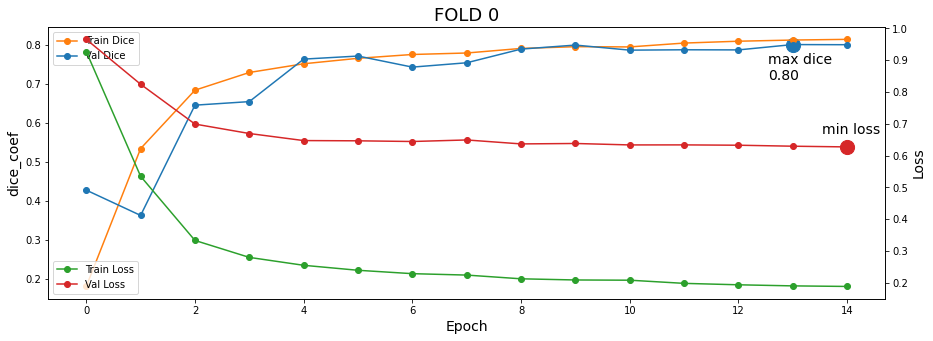

#################################################################
#### FOLD: 1
#### IMAGE_SIZE: (128, 128) | BATCH_SIZE: 256 | EPOCHS: 15
#### MODEL: UNet | BACKBONE: efficientnetb7 | LOSS: dice_loss
#### NUM_TRAIN: 30,960 | NUM_VALID: 7,248
#################################################################


2022-07-10 12:15:41.659228: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 317887, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657455341.658969753","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 317887, Output num: 0","grpc_status":3}



Valid Result:
29/29 [==============================] - 3s 80ms/step - loss: 0.3914 - dice_coef: 0.7442 - precision: 0.6432 - recall: 0.7689



2022-07-10 12:24:06.429824: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 465313, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657455846.429659486","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 465313, Output num: 3","grpc_status":3}


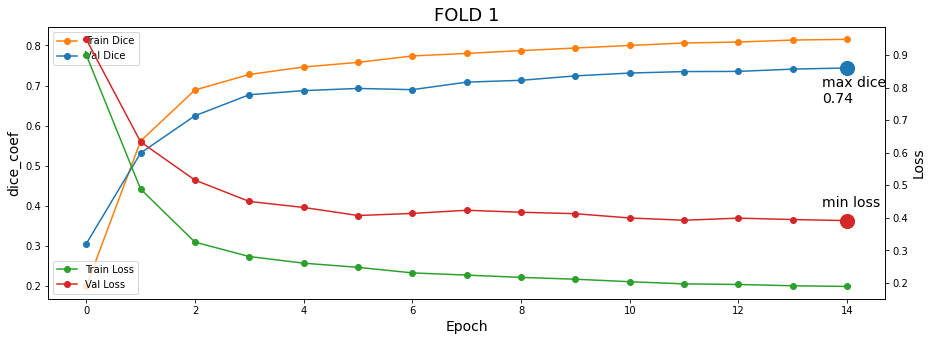

#################################################################
#### FOLD: 2
#### IMAGE_SIZE: (128, 128) | BATCH_SIZE: 256 | EPOCHS: 15
#### MODEL: UNet | BACKBONE: efficientnetb7 | LOSS: dice_loss
#### NUM_TRAIN: 30,608 | NUM_VALID: 7,600
#################################################################


2022-07-10 12:28:42.022302: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 578089, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657456122.021696075","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 578089, Output num: 0","grpc_status":3}



Valid Result:
30/30 [==============================] - 3s 79ms/step - loss: 0.4606 - dice_coef: 0.7371 - precision: 0.5519 - recall: 0.7851



2022-07-10 12:36:24.541640: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 675712, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657456584.541534486","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 675712, Output num: 2","grpc_status":3}


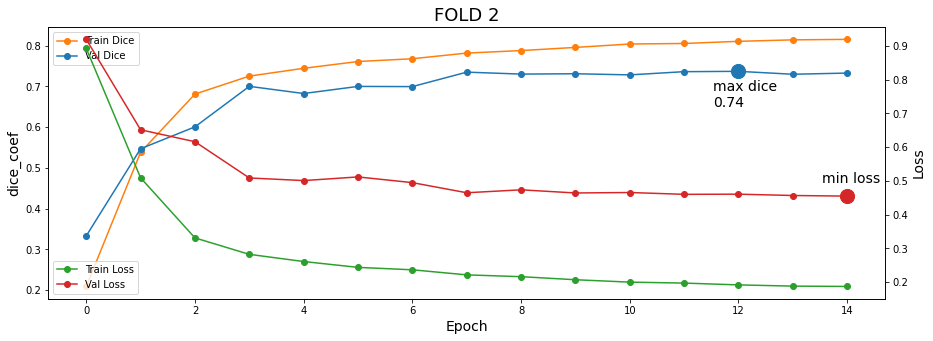

#################################################################
#### FOLD: 3
#### IMAGE_SIZE: (128, 128) | BATCH_SIZE: 256 | EPOCHS: 15
#### MODEL: UNet | BACKBONE: efficientnetb7 | LOSS: dice_loss
#### NUM_TRAIN: 30,048 | NUM_VALID: 8,160
#################################################################


2022-07-10 12:40:59.954828: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 788488, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657456859.954750343","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 788488, Output num: 2","grpc_status":3}



Valid Result:
32/32 [==============================] - 4s 79ms/step - loss: 0.5939 - dice_coef: 0.8136 - precision: 0.4292 - recall: 0.8337



2022-07-10 12:48:56.119820: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 907477, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657457336.118771440","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 907477, Output num: 1","grpc_status":3}


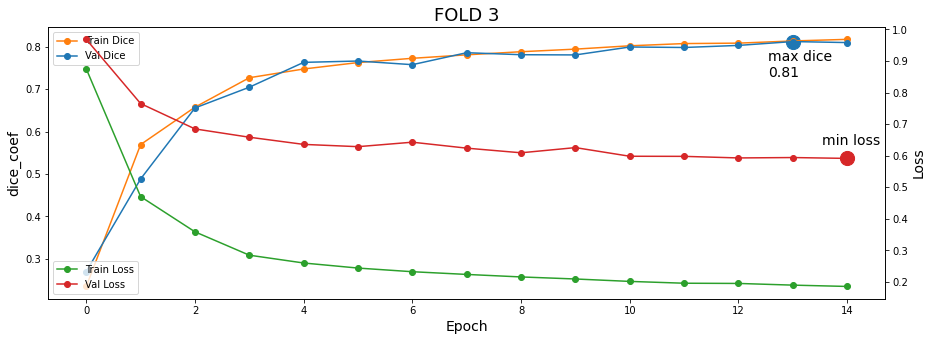

#################################################################
#### FOLD: 4
#### IMAGE_SIZE: (128, 128) | BATCH_SIZE: 256 | EPOCHS: 15
#### MODEL: UNet | BACKBONE: efficientnetb7 | LOSS: dice_loss
#### NUM_TRAIN: 30,784 | NUM_VALID: 7,424
#################################################################


2022-07-10 12:53:30.586589: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1020253, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657457610.585794757","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1020253, Output num: 0","grpc_status":3}



Valid Result:
29/29 [==============================] - 4s 81ms/step - loss: 0.6049 - dice_coef: 0.7902 - precision: 0.4041 - recall: 0.8395



2022-07-10 13:01:30.380896: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1132099, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657458090.380792788","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1132099, Output num: 1","grpc_status":3}


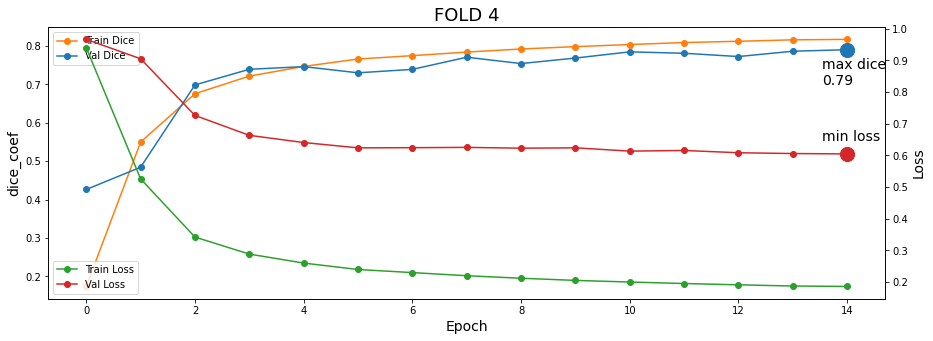

In [16]:
M = {}
# Which Metrics to store
metrics = [
    "loss",
    "dice_coef",
    "precision",
    "recall",
]
# Intialize Metrics
for fm in metrics:
    M["val_" + fm] = []

ALL_FILENAMES = sorted(ALL_FILENAMES)

# Split tfrecord using KFold
kf = KFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed) # kfold between trrecord files
for fold, (train_idx, valid_idx) in enumerate(kf.split(ALL_FILENAMES)):
    # If fold is not in selected folds then avoid that fold
    if fold not in CFG.selected_folds:
        continue
        
    # Train and validation files
    TRAIN_FILENAMES = [ALL_FILENAMES[i] for i in train_idx]
    VALID_FILENAMES = [ALL_FILENAMES[i] for i in valid_idx]
    
    # Take Only 10 Files if run in Debug Mode
    if CFG.debug:
        TRAIN_FILENAMES = TRAIN_FILENAMES[:10]
        VALID_FILENAMES = VALID_FILENAMES[:10]

    # Shuffle train files
    random.shuffle(TRAIN_FILENAMES)

    # Count train and valid samples
    NUM_TRAIN = count_data_items(TRAIN_FILENAMES)
    NUM_VALID = count_data_items(VALID_FILENAMES)

    # Compute batch size & steps_per_epoch
    BATCH_SIZE = CFG.batch_size * REPLICAS
    STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE

    print("#" * 65)
    print("#### FOLD:", fold)
    print(
        "#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"
        % (CFG.img_size[0], CFG.img_size[1], BATCH_SIZE, CFG.epochs)
    )
    print(
        "#### MODEL: %s | BACKBONE: %s | LOSS: %s"
        % (CFG.model_name, CFG.backbone, CFG.loss)
    )
    print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN, NUM_VALID))
    print("#" * 65)

   
    # Build model in device
    K.clear_session()
    with strategy.scope():
        model = get_model(name=CFG.model_name, backbone=CFG.backbone, loss=CFG.loss)

    # Callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/fold-%i.h5" % fold,
        verbose=CFG.verbose,
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )
    callbacks = [checkpoint, get_lr_callback()]

    # Create train & valid dataset
    train_ds = get_dataset(
        TRAIN_FILENAMES,
        augment=CFG.augment,
        batch_size=BATCH_SIZE,
        cache=False,
        drop_remainder=False,
    )
    valid_ds = get_dataset(
        VALID_FILENAMES,
        shuffle=False,
        augment=False,
        repeat=False,
        batch_size=BATCH_SIZE,
        cache=False,
        drop_remainder=False,
    )

    # Train model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs if not CFG.debug else 2,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=callbacks,
        validation_data=valid_ds,
        #         validation_steps = NUM_VALID/BATCH_SIZE,
        verbose=CFG.verbose,
    )

    # Convert dict history to df history
    history = pd.DataFrame(history.history)

    # Load best weights
    model.load_weights("/kaggle/working/fold-%i.h5" % fold)

    # Compute & save best valid result
    print("\nValid Result:")
    m = model.evaluate(
        get_dataset(
            VALID_FILENAMES,
            batch_size=BATCH_SIZE,
            augment=False,
            shuffle=False,
            repeat=False,
            cache=False,
        ),
        return_dict=True,
#        steps=NUM_VALID/BATCH_SIZE,
        verbose=1,
    )
    print()
    
    # Store valid results
    for fm in metrics:
        M["val_" + fm].append(m[fm])
        
 
    # Plot Training History
    if CFG.display_plot:
        plt.figure(figsize=(15, 5))
        plt.plot(
            np.arange(len(history["dice_coef"])),
            history["dice_coef"],
            "-o",
            label="Train Dice",
            color="#ff7f0e",
        )
        plt.plot(
            np.arange(len(history["dice_coef"])),
            history["val_dice_coef"],
            "-o",
            label="Val Dice",
            color="#1f77b4",
        )
        x = np.argmax(history["val_dice_coef"])
        y = np.max(history["val_dice_coef"])
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color="#1f77b4")
        plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max dice\n%.2f" % y, size=14)
        plt.ylabel("dice_coef", size=14)
        plt.xlabel("Epoch", size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(
            np.arange(len(history["dice_coef"])),
            history["loss"],
            "-o",
            label="Train Loss",
            color="#2ca02c",
        )
        plt2.plot(
            np.arange(len(history["dice_coef"])),
            history["val_loss"],
            "-o",
            label="Val Loss",
            color="#d62728",
        )
        x = np.argmin(history["val_loss"])
        y = np.min(history["val_loss"])
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color="#d62728")
        plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
        plt.ylabel("Loss", size=14)
        plt.title("FOLD %i" % (fold), size=18)
        plt.legend(loc=3)
        plt.savefig(f"fig-{fold}.png")
        plt.show()

# 15. Calculate OOF 👀
Let's check our average score across all folds. This will help us compare our model's performance.

In [17]:
# Save Metrics
M['datetime'] = str(datetime.now())
for fm in metrics:
    M['oof_'+fm] = np.mean(M['val_'+fm])
    print('OOF '+ fm + ': '+ str(M['oof_'+fm]))
with open('metrics.json', 'w') as outfile:
    json.dump(M, outfile)

OOF loss: 0.5361146092414856
OOF dice_coef: 0.7772060632705688
OOF precision: 0.48327391147613524
OOF recall: 0.814579713344574


In [18]:
#model.save_weights("TransUNet_TF_weights")
#model.save("TransUNet_TF.h5")